In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor


from sklearn.base import clone, BaseEstimator


import scipy
from scipy.io import arff


import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import wasserstein_distance as WD
from sklearn.metrics import *

from sklearn.model_selection import KFold

# Data: synthetic example

In [2]:
synthX = pd.read_csv('./SyntheticData/synth_tmp_noise.csv', index_col='Unnamed: 0')
synthY = pd.read_csv('./SyntheticData/synth_vegetation_urban.csv', index_col='Unnamed: 0')
synthYgt = pd.read_csv('./SyntheticData/synth_vegetation_no_urban.csv', index_col='Unnamed: 0')

# Cross-validation

In [3]:
class EnsembleRegressorChains (BaseEstimator):
    
    def __init__(self, base_estimator, 
                 n=10,
                 random_state=None):
        
        self.base_estimator = base_estimator
        self.n = n
        self.n_outputs = None
        self.random_state = random_state
        self.orders = []
        
    

    def fit(self, X, Y, **fit_params):
        
        self.n_outputs = Y.shape[1]
        
        self.orders = [[0,1,2],
                 [0,2,1],
                 [1,0,2],
                 [1,2,0],
                 [2,0,1],
                 [2,1,0]
                ]
        
        
        self.estimator_chains_ = [RegressorChain(self.base_estimator, 
                                                 order=o)
                                 for o in self.orders] 
        
        for i in range(len(self.orders)):   
                self.estimator_chains_[i].fit(X, Y)
                
        return self

    def predict(self, X):
        
        all_Y_pred = []
        
        for i in range(len(self.orders)):
            Y_pred_merged = self.estimator_chains_[i].predict(X)            
            Y_pred_one = Y_pred_merged[:,-self.n_outputs:]
            all_Y_pred.append(Y_pred_one)
        
        all_Y_pred_merged = np.array(all_Y_pred)
        Y_pred = np.mean(all_Y_pred_merged, axis=0)
        
        return Y_pred




In [4]:
def CrossValidation(X,Y):
    
    n_splits = 5
    labels = ['RC 012', 'RC 021', 'RC 102', 'RC 120', 'RC 201', 'RC 210', 'ERC', 'stRF', 'mtRF']
    models = [RegressorChain(RandomForestRegressor(), order=[0,1,2]),
              RegressorChain(RandomForestRegressor(), order=[0,2,1]),
              RegressorChain(RandomForestRegressor(), order=[1,0,2]),
              RegressorChain(RandomForestRegressor(), order=[1,2,0]),
              RegressorChain(RandomForestRegressor(), order=[2,0,1]),
              RegressorChain(RandomForestRegressor(), order=[2,1,0]),
              EnsembleRegressorChains(RandomForestRegressor()),
              MultiOutputRegressor(RandomForestRegressor()),
              RandomForestRegressor()
             ]
    logi = pd.DataFrame(index = labels, columns=list(range(n_splits)))
    
    kf = KFold(n_splits=n_splits)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
        for j, mdl in enumerate(models):
            mdl.fit(X_train, Y_train)
            Y_pred = mdl.predict(X_test)
            mse = mean_squared_error(Y_pred, Y_test)
            logi.loc[labels[j], i] = mse
        
    return logi.mean(axis=1)


In [5]:
logiCV = CrossValidation(synthX.to_numpy(), synthY.to_numpy())

# Metropolis-Hastings sampling inference

In [6]:
def getParamsNormal(base_mdl, X):
    
    preds = np.zeros((base_mdl.n_estimators, X.shape[0], 1))        
        
    # get predictions of individual trees in the random forest    
    for i, e in enumerate(base_mdl.estimators_):
        preds[i,:,:] = e.predict(X).reshape(-1,1)         
        
    # calculate mu and sigma of the distribution of predictions    
    mu = np.mean(preds, axis=0)
    sigma = np.std(preds, axis=0)
    
    return mu, sigma

In [7]:
def MHSampling(X, mdl, 
               order = [0,1,2], 
               yFixed = [None, None, 0]
               ):
    
    ### Estimate probability $\pi$ of 
    ### point $b$ in the distribution
    def _pi(b):
        
        X_ext = X.copy()
        pi = np.ones((b.shape[0],1))
        
        for n in order:
            
            mu, sigma = getParamsNormal(mdl.estimators_[order.index(n)], X_ext)
        
            X_ext = np.hstack((X_ext, b[:,n].reshape(-1,1)))
            
            p = scipy.stats.norm.cdf(b[:,n].reshape(-1,1) + 0.01, loc=mu, scale=sigma) - scipy.stats.norm.cdf(b[:,n].reshape(-1,1) - 0.01, loc=mu, scale=sigma) 
            p = np.nan_to_num(p, nan=0.001)
            
            pi = np.multiply(pi,p)
            

        return pi

    
    
    ### Propose new sample by adding noise 
    ### to the previous point and 
    ### forcing yFixed to provided values
    def _prop(b):
        y = b + np.random.normal(0, 0.1,size=b.shape)
        for n in order:
            if yFixed[n] is not None:
                y[:,n] = yFixed[n]
        return y
    
    
    ### Metropolis-Hastings Sampling ###
    
    b = mdl.predict(X)
    for n in order:
        if not yFixed[n] is None:
            b[:,n] = yFixed[n]
            
    trajectory = [b]
    n_iter = 500
    
    for i in range(1,n_iter):
        
        y = _prop(b)
        pi_b = _pi(b)
        pi_y = _pi(y)
        alpha = pi_y / pi_b
        alpha = np.where(alpha < 1, alpha, 1)
        r = np.random.rand(X.shape[0],1)
        
        b = np.where(r < alpha, y, b)
        
        trajectory.append(b)
        
        
    return np.array(trajectory)
        

# Experiments

## mhsERC

In [8]:
order = [0,1,2]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr012 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [9]:
order = [0,2,1]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr021 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [10]:
order = [1,0,2]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr102 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [11]:
order = [1,2,0]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr120 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [12]:
order = [2,0,1]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr201 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [13]:
order = [2,1,0]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

tr = MHSampling(synthX, mdl, order=order)
tr210 = tr / np.sum(tr, axis=2).reshape(tr.shape[0],tr.shape[1],1)

In [14]:
trEns = np.mean([tr012,tr021,tr102,tr120,tr201,tr210], axis=0)

## Marginal methods

In [15]:
def NaiveRedistribution(Y, yFixed = [None, None, 0]):
    Ynaive = Y.copy()
    
    for n in range(Y.shape[1]):
        if not yFixed[n] is None:
            Ynaive[:,n] = yFixed[n]
    
    Ynaive /= Ynaive.sum(axis=1).reshape(-1,1)
    
    return Ynaive
    

In [16]:
mdl = RandomForestRegressor()
mdl.fit(synthX, synthY)
Ypred = mdl.predict(synthX)
Ypred_mtRF = NaiveRedistribution(Ypred, yFixed = [None, None, 0])

In [17]:
mdl = MultiOutputRegressor(RandomForestRegressor())
mdl.fit(synthX, synthY)
Ypred = mdl.predict(synthX)
Ypred_stRF = NaiveRedistribution(Ypred, yFixed = [None, None, 0])

In [18]:
mdl = EnsembleRegressorChains(RandomForestRegressor())
mdl.fit(synthX, synthY)
Ypred = mdl.predict(synthX)
Ypred_ERC = NaiveRedistribution(Ypred, yFixed = [None, None, 0])

In [19]:
Y_naive_empty = NaiveRedistribution(synthY.to_numpy(), yFixed = [None, None, 0])

## Regressor Chains with 'convenient' order, no need for backward sampling

In [20]:
def RC_with_order(X, mdl, 
                  order = [2,1,0], 
                  yFixed = [None, None, 0]):
    
    X_ext = X.copy()
    
    y_pred = np.zeros((X.shape[0], len(mdl.estimators_)))
    for n in order:
        if not yFixed[n] is None:
            y_pred[:,n] = yFixed[n]
        else:
            y_pred[:,n] = mdl.estimators_[order.index(n)].predict(X_ext)
        
        X_ext = np.hstack((X_ext, y_pred[:,n].reshape(-1,1)))
        
    return y_pred
            

In [21]:
order = [2,1,0]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

Ypred_rc210 = RC_with_order(synthX, mdl, order=order)
Ypred_rc210 /= np.sum(Ypred_rc210, axis=1).reshape(-1,1)

In [22]:
order = [2,1,0]
mdl = RegressorChain(base_estimator=RandomForestRegressor(), order=order)
mdl.fit(synthX, synthY)

Ypred_rc201 = RC_with_order(synthX, mdl, order=order)
Ypred_rc201 /= np.sum(Ypred_rc201, axis=1).reshape(-1,1)

# Summary

In [23]:
def ucf_score(y_test, y_pred_test, delta = 0.5):
    
    y_diff = np.square(y_pred_test - y_test).sum(axis=1)
    y_diff = np.sqrt(y_diff)
    
    y_ucf = np.empty((y_diff.shape))
    y_ucf[np.where(y_diff <= delta/2)] = 0
    y_ucf[np.where(y_diff > delta/2)] = 1
    ucf = float(y_ucf.mean())
    
    return ucf

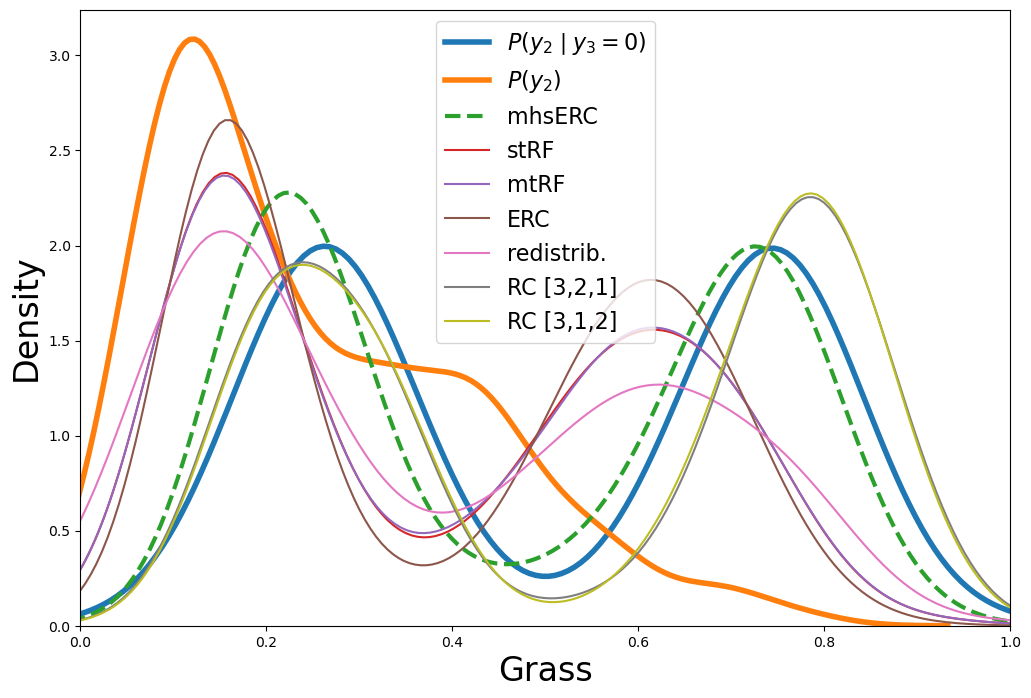

In [33]:
for i in [1]:
    fig, ax = plt.subplots(figsize=(12,8))
    
    sns.kdeplot(synthYgt.iloc[:,i], linewidth=4, label=r'$P(y_2 \mid y_3=0)$')
    sns.kdeplot(synthY.iloc[:,i], linewidth=4, label=r'$P(y_2)$')
    
    #sns.kdeplot(np.mean(tr012[:,:,i], axis=0), linestyle='dashed', label='mhsRC 012')
    #sns.kdeplot(np.mean(tr021[:,:,i], axis=0), linestyle='dashed', label='mhsRC 021')
    #sns.kdeplot(np.mean(tr102[:,:,i], axis=0), linestyle='dashed', label='mhsRC 102')
    #sns.kdeplot(np.mean(tr120[:,:,i], axis=0), linestyle='dashed', label='mhsRC 120')
    #sns.kdeplot(np.mean(tr201[:,:,i], axis=0), linestyle='dashed', label='mhsRC 201')
    #sns.kdeplot(np.mean(tr210[:,:,i], axis=0), linestyle='dashed', label='mhsRC 210')
    sns.kdeplot(np.mean(trEns[:,:,i], axis=0), linewidth=3, linestyle='dashed', label='mhsERC')
    
    
    
    sns.kdeplot(Ypred_stRF[:,i], label='stRF')
    sns.kdeplot(Ypred_mtRF[:,i], label='mtRF')
    sns.kdeplot(Ypred_ERC[:,i], label='ERC')
    sns.kdeplot(Y_naive_empty[:,i], label='redistrib.')
    sns.kdeplot(Ypred_rc210[:,i], label='RC [3,2,1]')
    sns.kdeplot(Ypred_rc201[:,i], label='RC [3,1,2]')
    

    ax.legend(fontsize=16)
    ax.set_xlabel('Grass', fontsize=24)
    ax.set_ylabel('Density', fontsize=24)  

    ax.set_xlim(0,1)
    
    plt.show()

In [26]:
logi = pd.DataFrame(columns = ['cv MSE', 'MSE', 'WD', 'UCF']
                   )

################################################################

logi.loc['mhsRC [1,2,3]', 'cv MSE'] = logiCV.loc['RC 012']
logi.loc['mhsRC [1,3,2]', 'cv MSE'] = logiCV.loc['RC 021']
logi.loc['mhsRC [2,1,3]', 'cv MSE'] = logiCV.loc['RC 102']
logi.loc['mhsRC [2,3,1]', 'cv MSE'] = logiCV.loc['RC 120']
logi.loc['mhsRC [3,1,2]', 'cv MSE'] = logiCV.loc['RC 201']
logi.loc['mhsRC [3,2,1]', 'cv MSE'] = logiCV.loc['RC 210']
logi.loc['mhsERC', 'cv MSE'] = logiCV.loc['ERC']

logi.loc['stRF', 'cv MSE'] = logiCV.loc['stRF']
logi.loc['mtRF', 'cv MSE'] = logiCV.loc['mtRF']
logi.loc['ERC', 'cv MSE'] = logiCV.loc['ERC']
logi.loc['redistrib.', 'cv MSE'] = np.nan
logi.loc['RC [3,2,1]', 'cv MSE'] = logiCV.loc['RC 210']
logi.loc['RC [3,1,2]', 'cv MSE'] = logiCV.loc['RC 201']


################################################################

logi.loc['mhsRC [1,2,3]', 'MSE'] = mean_squared_error(np.mean(tr012[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [1,3,2]', 'MSE'] = mean_squared_error(np.mean(tr021[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [2,1,3]', 'MSE'] = mean_squared_error(np.mean(tr102[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [2,3,1]', 'MSE'] = mean_squared_error(np.mean(tr120[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [3,1,2]', 'MSE'] = mean_squared_error(np.mean(tr201[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [3,2,1]', 'MSE'] = mean_squared_error(np.mean(tr210[:,:,:2], axis=0), synthYgt)
logi.loc['mhsERC', 'MSE'] = mean_squared_error(np.mean(trEns[:,:,:2], axis=0), synthYgt)


logi.loc['mtRF', 'MSE'] = mean_squared_error(Ypred_mtRF[:,:2], synthYgt)
logi.loc['stRF', 'MSE'] = mean_squared_error(Ypred_stRF[:,:2], synthYgt)
logi.loc['ERC', 'MSE'] = mean_squared_error(Ypred_ERC[:,:2], synthYgt)
logi.loc['redistrib.', 'MSE'] = mean_squared_error(Y_naive_empty[:,:2], synthYgt)
logi.loc['RC [3,2,1]', 'MSE'] = mean_squared_error(Ypred_rc210[:,:2], synthYgt)
logi.loc['RC [3,1,2]', 'MSE'] = mean_squared_error(Ypred_rc201[:,:2], synthYgt)

################################################################

logi.loc['mhsRC [1,2,3]', 'WD'] = WD(np.mean(tr012[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsRC [1,3,2]', 'WD'] = WD(np.mean(tr021[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsRC [2,1,3]', 'WD'] = WD(np.mean(tr102[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsRC [2,3,1]', 'WD'] = WD(np.mean(tr120[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsRC [3,1,2]', 'WD'] = WD(np.mean(tr201[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsRC [3,2,1]', 'WD'] = WD(np.mean(tr210[:,:,1], axis=0), synthYgt.iloc[:,1])
logi.loc['mhsERC', 'WD'] = WD(np.mean(trEns[:,:,1], axis=0), synthYgt.iloc[:,1])


logi.loc['mtRF', 'WD'] = WD(Ypred_mtRF[:,1], synthYgt.iloc[:,1])
logi.loc['stRF', 'WD'] = WD(Ypred_stRF[:,1], synthYgt.iloc[:,1])
logi.loc['ERC', 'WD'] = WD(Ypred_ERC[:,1], synthYgt.iloc[:,1])
logi.loc['redistrib.', 'WD'] = WD(Y_naive_empty[:,1], synthYgt.iloc[:,1])
logi.loc['RC [3,2,1]', 'WD'] = WD(Ypred_rc210[:,1], synthYgt.iloc[:,1])
logi.loc['RC [3,1,2]', 'WD'] = WD(Ypred_rc201[:,1], synthYgt.iloc[:,1])


################################################################

logi.loc['mhsRC [1,2,3]', 'UCF'] = ucf_score(np.mean(tr012[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [1,3,2]', 'UCF'] = ucf_score(np.mean(tr021[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [2,1,3]', 'UCF'] = ucf_score(np.mean(tr102[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [2,3,1]', 'UCF'] = ucf_score(np.mean(tr120[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [3,1,2]', 'UCF'] = ucf_score(np.mean(tr201[:,:,:2], axis=0), synthYgt)
logi.loc['mhsRC [3,2,1]', 'UCF'] = ucf_score(np.mean(tr210[:,:,:2], axis=0), synthYgt)
logi.loc['mhsERC', 'UCF'] = ucf_score(np.mean(trEns[:,:,:2], axis=0), synthYgt)


logi.loc['mtRF', 'UCF'] = ucf_score(Ypred_mtRF[:,:2], synthYgt)
logi.loc['stRF', 'UCF'] = ucf_score(Ypred_stRF[:,:2], synthYgt)
logi.loc['ERC', 'UCF'] = ucf_score(Ypred_ERC[:,:2], synthYgt)
logi.loc['redistrib.', 'UCF'] = ucf_score(Y_naive_empty[:,:2], synthYgt)
logi.loc['RC [3,2,1]', 'UCF'] = ucf_score(Ypred_rc210[:,:2], synthYgt)
logi.loc['RC [3,1,2]', 'UCF'] = ucf_score(Ypred_rc201[:,:2], synthYgt)

################################################################

logi = logi.applymap("{0:.3f}".format)
logi

,cv MSE,MSE,WD,UCF
"mhsRC [1,2,3]",0.016,0.012,0.030,0.060
"mhsRC [1,3,2]",0.015,0.005,0.014,0.026
"mhsRC [2,1,3]",0.017,0.029,0.099,0.241
"mhsRC [2,3,1]",0.017,0.029,0.118,0.261
"mhsRC [3,1,2]",0.017,0.008,0.016,0.047
"mhsRC [3,2,1]",0.017,0.011,0.038,0.063
mhsERC,0.015,0.006,0.031,0.030
stRF,0.018,0.019,0.116,0.175
mtRF,0.018,0.019,0.115,0.176
ERC,0.015,0.018,0.114,0.170
